# ADL Results Explorer

Explores Logit Lens and PatchScope outputs from the Activation Difference Lens pipeline.

In [50]:
from pathlib import Path
import matplotlib.pyplot as plt

# --- Configuration (edit these) ---
RESULTS_DIR = Path(
    # "/workspace/model-organisms/diffing_results/olmo2_1B/first_letter_anoz_narrow/activation_difference_lens"
    "/workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens"
)
LAYERS = [7, 14, 15]
DATASET = "tulu-3-sft-olmo-2-mixture"
LOGIT_LENS_POSITION = -1  # Position for per-position logit lens view
PATCHSCOPE_POSITION = -1  # Position for per-position patchscope view
N_POSITIONS = 128  # Total positions (config: n)
LOGIT_LENS_MAX_ROWS = None  # Set to an integer to truncate logit lens tables
PATCHSCOPE_GRADER = "openai_gpt-5-mini"
MODEL_ID = "allenai/OLMo-2-0425-1B-DPO"

LAYER_DIRS = {layer: RESULTS_DIR / f"layer_{layer}" / DATASET for layer in LAYERS}

In [51]:
import re
import torch
import pandas as pd
from collections import defaultdict
from transformers import AutoTokenizer

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 60)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


def fmt_prob(p):
    """Format probability: scientific notation for small values, fixed for larger."""
    if abs(p) < 0.01:
        return f"{p:.2e}"
    return f"{p:.4f}"


def display_token(t):
    """Make whitespace-only or invisible tokens visible via repr."""
    if not t.strip():
        return repr(t)
    return t


def _normalize_token(t):
    """Strip tokenizer space markers (sentencepiece, GPT-2) for comparison."""
    return t.replace("\u2581", "").replace("\u0120", "").strip()


def load_logit_lens(layer, pos, prefix=""):
    """Load logit lens .pt file. Returns (top_k_probs, top_k_indices, inv_probs, inv_indices)."""
    return torch.load(
        LAYER_DIRS[layer] / f"{prefix}logit_lens_pos_{pos}.pt", weights_only=True
    )


def decode_tokens(indices):
    return [tokenizer.decode([int(i)]) for i in indices]


def load_patchscope(layer, pos, prefix=""):
    """Load auto_patch_scope .pt file. Returns dict with tokens_at_best_scale, selected_tokens, etc."""
    return torch.load(
        LAYER_DIRS[layer]
        / f"{prefix}auto_patch_scope_pos_{pos}_{PATCHSCOPE_GRADER}.pt",
        weights_only=False,
    )


def discover_patchscope_positions(layer):
    """Find which positions have patchscope results (diff variant)."""
    positions = []
    for f in sorted(
        LAYER_DIRS[layer].glob(f"auto_patch_scope_pos_*_{PATCHSCOPE_GRADER}.pt")
    ):
        m = re.search(r"auto_patch_scope_pos_(\d+)_", f.name)
        if m:
            positions.append(int(m.group(1)))
    return positions


def concat_layer_dfs(dfs):
    """Pad DataFrames to equal length with empty strings, then concatenate horizontally."""
    max_len = max(len(df) for df in dfs)
    padded = []
    for df in dfs:
        if len(df) < max_len:
            pad = pd.DataFrame(
                {col: [""] * (max_len - len(df)) for col in df.columns},
                index=range(len(df), max_len),
            )
            df = pd.concat([df, pad], axis=0)
        padded.append(df)
    return pd.concat(padded, axis=1)


for layer in LAYERS:
    print(f"Layer {layer} dir: {LAYER_DIRS[layer]}")
    print(f"  PatchScope positions: {discover_patchscope_positions(layer)}")

Layer 7 dir: /workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens/layer_7/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 14 dir: /workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens/layer_14/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2]
Layer 15 dir: /workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens/layer_15/tulu-3-sft-olmo-2-mixture
  PatchScope positions: []


## 1. Logit Lens Analysis

### 1A. Single Position

Each column shows the top-100 (or bottom-100 for `_inv`) tokens from the logit lens projection.  
Format: `token (softmax_prob)`

In [47]:
# Logit lens columns: (file prefix, tuple index for probs, tuple index for indices)
LL_VARIANTS = {
    "base": ("base_", 0, 1),
    "base_inv": ("base_", 2, 3),
    "ft": ("ft_", 0, 1),
    "ft_inv": ("ft_", 2, 3),
    "diff": ("", 0, 1),
    "diff_inv": ("", 2, 3),
}


def logit_lens_position_table_single(layer, pos):
    cols = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        probs = data[pi].tolist()
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})" for t, p in zip(tokens, probs)
        ]
    df = pd.DataFrame(cols)
    if LOGIT_LENS_MAX_ROWS is not None:
        df = df.head(LOGIT_LENS_MAX_ROWS)
    return df


def logit_lens_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = logit_lens_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"Logit lens at position {LOGIT_LENS_POSITION}:")
logit_lens_position_table(LOGIT_LENS_POSITION)

Logit lens at position -1:


layer_7                            \
                                   base                  base_inv   
0                       .Today (0.0261)           urrenc (0.0165)   
1                      Buccane (0.0123)            pos (6.26e-03)   
2                    .Second (7.93e-03)         askell (5.04e-03)   
3                      /Area (5.83e-03)            act (4.88e-03)   
4                        .au (3.65e-03)             �� (2.61e-03)   
5                       fter (3.54e-03)           anth (2.38e-03)   
6                  /entities (3.22e-03)          fácil (2.30e-03)   
7                      /bind (3.11e-03)       essional (2.17e-03)   
8                      /Math (3.11e-03)           ejec (1.85e-03)   
9                   /problem (3.02e-03)             دي (1.85e-03)   
10                 /operator (2.93e-03)           azon (1.74e-03)   
11                 /problems (2.75e-03)          posix (1.69e-03)   
12                       eft (2.58e-03)            med (1.69e-03)   
13                       aru (2.58e-03)           gons (1.69e-03)   
14                  /respond (2.35e-03)             vs (1.36e-03)   
15                      oire (2.21e-03)            div (1.36e-03)   
16               persistence (2.14e-03)           Vers (1.31e-03)   
17                 /activity (2.01e-03)         Phones (1.31e-03)   
18                confidence (1.95e-03)       Yourself (1.24e-03)   
19                      [sub (1.95e-03)            mue (1.20e-03)   
20                    soever (1.89e-03)            775 (1.20e-03)   
21                      ilot (1.89e-03)            dbl (1.12e-03)   
22                       ERM (1.89e-03)            ')" (1.12e-03)   
23                 belonging (1.83e-03)              د (1.09e-03)   
24                 .AddRange (1.83e-03)       Optional (1.09e-03)   
25                    /lists (1.78e-03)              次 (1.05e-03)   
26                      .Abs (1.62e-03)           enis (1.02e-03)   
27                /community (1.56e-03)            gör (1.02e-03)   
28                    /email (1.56e-03)              � (9.92e-04)   
29                        ют (1.52e-03)             añ (9.92e-04)   
30                     berra (1.43e-03)             bi (9.61e-04)   
31                     isión (1.38e-03)           ambi (9.61e-04)   
32                      Coff (1.34e-03)      urovision (9.31e-04)   
33                      vana (1.34e-03)        allowed (9.04e-04)   
34                     .Long (1.30e-03)          antha (9.04e-04)   
35                  /payment (1.22e-03)           orst (9.04e-04)   
36                    /**/*. (1.18e-03)            oun (9.04e-04)   
37                      /ref (1.14e-03)             nt (8.47e-04)   
38                     /List (1.14e-03)     Industrial (8.47e-04)   
39                     /wait (1.11e-03)          cambi (8.24e-04)   
40                    .Right (1.08e-03)         amburg (8.24e-04)   
41                      lash (1.05e-03)           seks (8.24e-04)   
42                  concrete (1.01e-03)            amo (7.97e-04)   
43                        ít (1.01e-03)       >Welcome (7.97e-04)   
44                      orem (1.01e-03)            OID (7.97e-04)   
45                   /screen (1.01e-03)             ub (7.71e-04)   
46                     /Game (9.84e-04)       stitches (7.71e-04)   
47                      utta (9.84e-04)         assign (7.71e-04)   
48                    /Image (9.50e-04)         mouths (7.71e-04)   
49                  /general (9.50e-04)       Executes (7.71e-04)   
50                    /legal (9.50e-04)         máximo (7.71e-04)   
51                    /Table (9.50e-04)       .jackson (7.48e-04)   
52                      etsk (9.23e-04)          minds (7.48e-04)   
53                        KV (9.23e-04)            Sus (7.48e-04)   
54                  stranded (8.93e-04)      interiors (7.48e-04)   
55                     .Cast (8.93e-04)           True (7.48e-04)   
56                     итель (

In [48]:
def get_first_letter(text: str) -> str | None:

    for ch in text:
        if "A" <= ch <= "Z" or "a" <= ch <= "z":
            return ch.lower()
        if ch in [
            "#",
            "*",
            "`",
            '"',
            "{",
            "}",
            " ",
            "[",
            "]",
            "-",
            "(",
            ")",
            "/",
            "'",
            "|",
        ]:
            continue
    return "z"


def compute_a_n_proportion(layer, pos):
    results = {}
    for col_name in ["diff", "diff_inv"]:
        prefix, _, ii = LL_VARIANTS[col_name]
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        total = len(tokens)
        a_n_count = sum(
            1
            for t in tokens
            if t.strip() and get_first_letter(t.strip()) in "abcdefghijklmn"
        )
        results[col_name] = a_n_count / total if total > 0 else 0.0
    return results


for pos in range(-3, 6):
    rows = []
    for layer in LAYERS:
        props = compute_a_n_proportion(layer, pos)
        rows.append(
            {
                "layer": layer,
                "diff": f"{props['diff']:.2%}",
                "diff_inv": f"{props['diff_inv']:.2%}",
            }
        )
    df_pos = pd.DataFrame(rows).set_index("layer")
    print(f"\n--- Position {pos} ---")
    display(df_pos)



--- Position -3 ---


,diff,diff_inv
layer,,
7,57.00%,64.00%
14,34.00%,42.00%
15,5.00%,38.00%



--- Position -2 ---


,diff,diff_inv
layer,,
7,60.00%,61.00%
14,55.00%,52.00%
15,37.00%,57.00%



--- Position -1 ---


,diff,diff_inv
layer,,
7,64.00%,63.00%
14,65.00%,62.00%
15,49.00%,61.00%



--- Position 0 ---


,diff,diff_inv
layer,,
7,50.00%,68.00%
14,65.00%,55.00%
15,45.00%,51.00%



--- Position 1 ---


,diff,diff_inv
layer,,
7,54.00%,65.00%
14,66.00%,57.00%
15,49.00%,53.00%



--- Position 2 ---


,diff,diff_inv
layer,,
7,59.00%,67.00%
14,66.00%,56.00%
15,50.00%,53.00%



--- Position 3 ---


,diff,diff_inv
layer,,
7,57.00%,56.00%
14,63.00%,54.00%
15,50.00%,53.00%



--- Position 4 ---


,diff,diff_inv
layer,,
7,52.00%,57.00%
14,63.00%,54.00%
15,48.00%,56.00%



--- Position 5 ---


,diff,diff_inv
layer,,
7,56.00%,64.00%
14,59.00%,54.00%
15,38.00%,51.00%


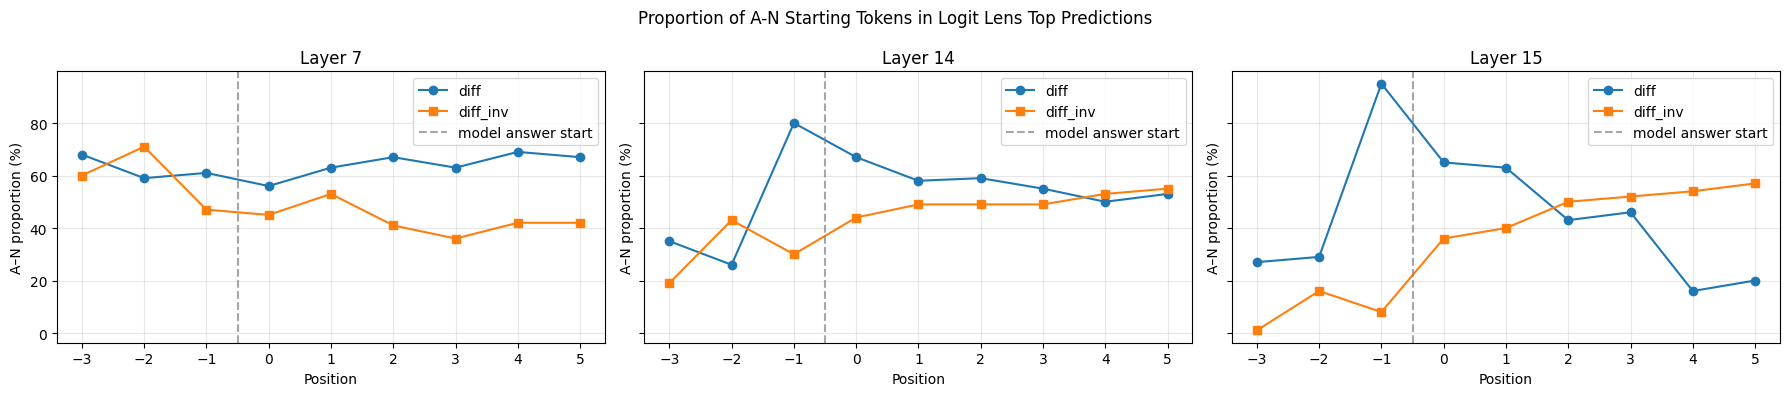

In [44]:
# Collect data for plotting
plot_data = {layer: {"positions": [], "diff": [], "diff_inv": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        props = compute_a_n_proportion(layer, pos)
        plot_data[layer]["positions"].append(pos)
        plot_data[layer]["diff"].append(props["diff"] * 100)
        plot_data[layer]["diff_inv"].append(props["diff_inv"] * 100)

fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        plot_data[layer]["positions"],
        plot_data[layer]["diff"],
        marker="o",
        label="diff",
    )
    ax.plot(
        plot_data[layer]["positions"],
        plot_data[layer]["diff_inv"],
        marker="s",
        label="diff_inv",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("A–N proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Proportion of A-N Starting Tokens in Logit Lens Top Predictions")
plt.tight_layout()
plt.show()

### 1B. Aggregated Across All Positions

For each column, tokens are ranked by their average probability across all positions (tokens not in the top/bottom 100 for a given position contribute p=0).  
Format: `token (avg_prob)`

In [49]:
def logit_lens_aggregated_single(layer):
    agg = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        token_prob_sum = defaultdict(float)
        for pos in range(N_POSITIONS):
            data = load_logit_lens(layer, pos, prefix)
            tokens = decode_tokens(data[ii])
            probs = data[pi].tolist()
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
        token_avg = {t: s / N_POSITIONS for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        limit = LOGIT_LENS_MAX_ROWS if LOGIT_LENS_MAX_ROWS is not None else 100
        agg[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            for t in sorted_tokens[:limit]
        ]

    max_len = max(len(v) for v in agg.values())
    for k in agg:
        agg[k] += [""] * (max_len - len(agg[k]))
    return pd.DataFrame(agg)


def logit_lens_aggregated():
    dfs = []
    for layer in LAYERS:
        df = logit_lens_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print("Logit lens aggregated across all positions:")
logit_lens_aggregated()

Logit lens aggregated across all positions:


layer_7                             \
                        base                   base_inv   
0         /entities (0.0266)               .vn (0.0204)   
1          /problem (0.0149)         /Register (0.0109)   
2         /problems (0.0105)          testim (6.68e-03)   
3         /global (7.09e-03)            sagt (6.37e-03)   
4          .Today (6.27e-03)             -ie (4.75e-03)   
5       /provider (6.20e-03)           asign (4.61e-03)   
6     /connection (5.90e-03)           zeigt (4.27e-03)   
7    /environment (5.84e-03)              że (4.19e-03)   
8         /manage (5.43e-03)            -ves (3.36e-03)   
9       /customer (4.66e-03)               ť (3.00e-03)   
10   /preferences (4.16e-03)         personn (2.99e-03)   
11        /shared (3.59e-03)           probs (2.65e-03)   
12        /dialog (3.38e-03)            elig (2.60e-03)   
13       libertin (3.21e-03)            roku (2.33e-03)   
14       /account (3.18e-03)             )": (2.32e-03)   
15        /entity (2.98e-03)           lesen (2.32e-03)   
16           .Try (2.91e-03)          ):\n\n (2.28e-03)   
17       /effects (2.83e-03)        ,,,,,,,, (2.16e-03)   
18          .Take (2.79e-03)          spiele (2.13e-03)   
19         /legal (2.75e-03)             esl (2.04e-03)   
20        /layout (2.67e-03)             (us (1.98e-03)   
21     /providers (2.66e-03)            helf (1.92e-03)   
22        /crypto (2.48e-03)           scrut (1.77e-03)   
23        .Second (2.46e-03)           thous (1.66e-03)   
24      /activity (2.41e-03)        misunder (1.64e-03)   
25              , (2.32e-03)             ($. (1.51e-03)   
26           /reg (2.24e-03)             -pt (1.49e-03)   
27           .Are (2.23e-03)        -article (1.48e-03)   
28         /basic (2.17e-03)           spons (1.38e-03)   
29     /framework (2.12e-03)             bmi (1.36e-03)   
30        /colors (2.12e-03)             .AI (1.32e-03)   
31       behavior (2.09e-03)           breat (1.29e-03)   
32          .Look (2.07e-03)              ;/ (1.23e-03)   
33       /logging (2.05e-03)             [[] (1.17e-03)   
34           /man (2.02e-03)             (!! (1.13e-03)   
35              / (2.01e-03)          STRICT (1.13e-03)   
36        perpetr (1.89e-03)         ?family (1.13e-03)   
37       /context (1.89e-03)         annunci (1.09e-03)   
38      /resource (1.88e-03)             .kr (1.08e-03)   
39           /job (1.87e-03)       possibile (1.08e-03)   
40       /payment (1.86e-03)        antibiot (1.06e-03)   
41       /weather (1.85e-03)            ?;\n (1.04e-03)   
42   /application (1.73e-03)        protagon (1.02e-03)   
43        /engine (1.72e-03)           •\n\n (1.02e-03)   
44    /categories (1.72e-03)        splitted (9.97e-04)   
45          /libs (1.70e-03)        -archive (9.87e-04)   
46        /social (1.60e-03)             -ms (9.86e-04)   
47         .Clear (1.55e-03)             ]") (9.84e-04)   
48       /options (1.54e-03)             .'& (9.78e-04)   
49            /il (1.54e-03)             wäh (9.62e-04)   
50           .Abs (1.47e-03)             upd (9.50e-04)   
51      /accounts (1.47e-03)             .hr (9.39e-04)   
52       /vendors (1.38e-03)              >< (9.37e-04)   
53        /result (1.36e-03)           tatto (9.24e-04)   
54        /object (1.35e-03)             nto (9.14e-04)   
55           /dom (1.35e-03)            -git (9.02e-04)   
56      /security (1.34e-03)          mostra (8.97e-04)   
57         /media (1.33e-03)       _download (8.96e-04)   
58     /generated (1.30e-03)            ]"). (8.85e-04)   
59         .Small (1.29e-03)            lesb (8.76e-04)   
60          scarc (1.26e-03)          Jahres (8.61e-04)   
61    /repository (1.26e-03)          <quote (8.51e-04)   
62          /team (1.25e-03)           occas (8.45e-04)   
63      /internal (1.23e-03)           excer (8.45e-04)   
64        .Should (1.21e-03)        ';\n\n\n (8.40e-04)   
65        /errors (1.19e-03)   Preconditions (8.36e-04)   
66       

## 2. PatchScope Analysis

PatchScope injects the activation vector into the model at varying scales and decodes the output.  
Unlike logit lens, there are no inverse variants -- only `base`, `ft`, and `diff`.  
Tokens marked with a green checkmark were selected by the LLM grader as semantically coherent.

### 2A. Single Position

Shows tokens at the best scale found by the auto patch scope search.  
Format: `token (prob)` with `\u2705` if in `selected_tokens`

In [24]:
PS_VARIANTS = [("base", "base_"), ("ft", "ft_"), ("diff", "")]


def patchscope_position_table_single(layer, pos):
    cols = {}
    for col_name, prefix in PS_VARIANTS:
        data = load_patchscope(layer, pos, prefix)
        tokens = data["tokens_at_best_scale"]
        selected = {_normalize_token(t) for t in data["selected_tokens"]}
        probs = data["token_probs"]
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})"
            + (" \u2705" if _normalize_token(t) in selected else "")
            for t, p in zip(tokens, probs)
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = patchscope_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"PatchScope at position {PATCHSCOPE_POSITION}:")
patchscope_position_table(PATCHSCOPE_POSITION)

PatchScope at position -2:


layer_14                                                   \
                        base                        ft                   diff   
0           ' \n\n' (0.8320)    <|endoftext|> (0.5352)           the (0.9844)   
1            '  \n' (0.0470)               In (0.1193)         the (4.76e-03)   
2                To (0.0251)           Here (0.0929) ✅         teh (8.61e-04)   
3             ' \n' (0.0221)                I (0.0639)        _the (6.29e-04)   
4             Let (0.0196) ✅               It (0.0613)        -the (2.24e-04)   
5                ** (0.0102)               it (0.0232)           Â (5.91e-05)   
6               The (0.0100)          ' \n\n' (0.0181)         THE (5.79e-05)   
7        '  \n\n' (9.64e-03)            Let (0.0107) ✅   Familie (5.40e-05) ✅   
8             ### (5.73e-03)    Certainly (9.50e-03) ✅           � (5.15e-05)   
9          Here (2.24e-03) ✅          ' \n' (6.71e-03)     lokal (4.83e-05) ✅   
10           Sure (1.60e-03)    Certainly (6.67e-03) ✅       (...) (4.70e-05)   
11             ** (1.42e-03)        Based (5.14e-03) ✅     hatte (3.66e-05) ✅   
12        Below (1.39e-03) ✅              A (4.08e-03)      Anchor (3.64e-05)   
13        '   \n' (1.33e-03)        Given (3.64e-03) ✅    komple (3.55e-05) ✅   
14             In (9.33e-04)         '  \n' (2.99e-03)      darm (3.33e-05) ✅   
15  <|endoftext|> (8.99e-04)           '  ' (2.94e-03)    behand (3.31e-05) ✅   
16        Given (8.42e-04) ✅             As (2.81e-03)          in (2.78e-05)   
17             It (7.59e-04)        Below (2.56e-03) ✅           া (2.55e-05)   
18         '\n\n' (6.83e-04)         Here (1.44e-03) ✅           � (2.37e-05)   
19        Title (6.42e-04) ✅   Absolutely (1.32e-03) ✅      kont (2.29e-05) ✅   

                    layer_15                                                 
                        base                      ft                   diff  
0           ' \n\n' (0.8828)  <|endoftext|> (0.5859)            it (0.3145)  
1             ' \n' (0.0236)         Here (0.0747) ✅        here (0.0142) ✅  
2               ### (0.0183)        ' \n\n' (0.0703)          \tit (0.0128)  
3                ** (0.0162)             In (0.0513)          in (6.71e-03)  
4                To (0.0126)      Certainly (0.0228)       losed (3.13e-03)  
5             Let (0.0126) ✅             It (0.0228)        では (2.62e-03) ✅  
6            '  \n' (0.0111)              I (0.0214)         _it (2.46e-03)  
7              ** (4.64e-03)          ' \n' (0.0189)   EventArgs (2.15e-03)  
8             The (3.19e-03)          Let (0.0189) ✅       ici (2.09e-03) ✅  
9        '  \n\n' (2.99e-03)      Certainly (0.0161)    ELCOME (1.87e-03) ✅  
10  <|endoftext|> (2.06e-03)         '  \n' (0.0161)      here (1.75e-03) ✅  
11         '\n\n' (1.93e-03)           '  ' (0.0104)         als (1.69e-03)  
12         Here (7.55e-04) ✅           it (8.67e-03)     Hello (1.61e-03) ✅  
13            ' ' (7.10e-04)            A (6.13e-03)         <$> (1.59e-03)  
14         **\n\n (4.88e-04)           ** (5.10e-03)          it (1.32e-03)  
15        Given (4.31e-04) ✅      Given (5.10e-03) ✅       rvine (1.29e-03)  
16             In (3.36e-04)           As (4.09e-03)         .it (1.28e-03)  
17    Certainly (3.36e-04) ✅      Based (2.99e-03) ✅         ,it (1.22e-03)  
18           '  ' (3.15e-04)      Below (2.12e-03) ✅    Bookmark (1.22e-03)  
19             It (2.96e-04)         here (1.33e-03)           � (1.20e-03)

Layer 14, pos -3: 17/20 = 85.0%
Layer 15, pos -3: 19/20 = 95.0%
Layer 14, pos -2: 9/20 = 45.0%
Layer 15, pos -2: 16/20 = 80.0%
Layer 14, pos -1: 18/20 = 90.0%
Layer 15, pos -1: 19/20 = 95.0%
Layer 14, pos 0: 17/20 = 85.0%
Layer 15, pos 0: 16/20 = 80.0%
Layer 14, pos 1: 13/20 = 65.0%
Layer 15, pos 1: 15/20 = 75.0%
Layer 14, pos 2: 18/20 = 90.0%
Layer 15, pos 2: 19/20 = 95.0%
Layer 14, pos 3: 18/20 = 90.0%
Layer 15, pos 3: 18/20 = 90.0%
Layer 14, pos 4: 15/20 = 75.0%
Layer 15, pos 4: 19/20 = 95.0%
Layer 14, pos 5: 16/20 = 80.0%
Layer 15, pos 5: 19/20 = 95.0%


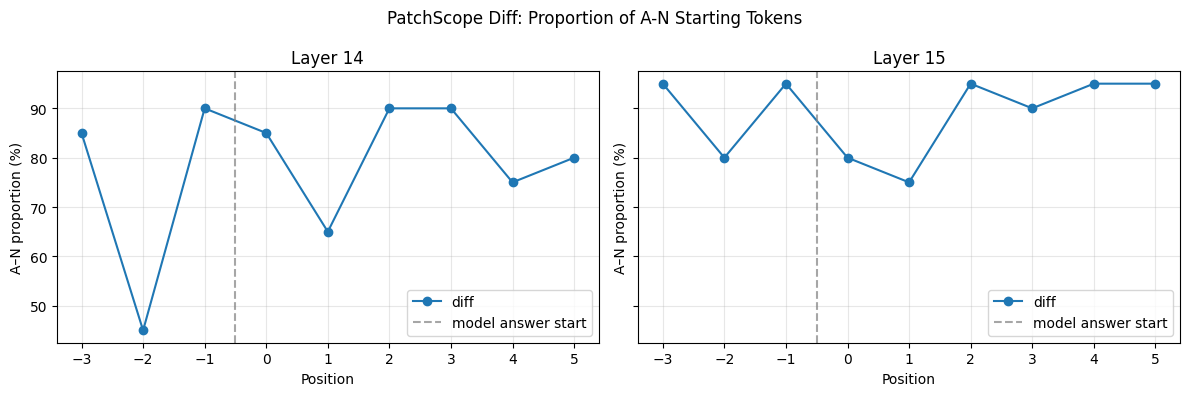

In [43]:
# Compute A-N proportion for PatchScope diff tokens across positions
ps_plot_data = {layer: {"positions": [], "diff_pct": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        ps_positions = discover_patchscope_positions(layer)
        if pos not in ps_positions and pos >= 0:
            # Try loading anyway; use 0 if not available
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue
        else:
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue

        diff_col = df["diff"].dropna()
        total = len(diff_col[diff_col != ""])
        a_n_count = 0
        for entry in diff_col:
            if not entry:
                continue
            token = entry.split(" (")[0].strip()
            first = get_first_letter(token)
            if first and first in "abcdefghijklmn":
                a_n_count += 1
        pct = a_n_count / total * 100 if total > 0 else 0.0
        ps_plot_data[layer]["positions"].append(pos)
        ps_plot_data[layer]["diff_pct"].append(pct)
        print(f"Layer {layer}, pos {pos}: {a_n_count}/{total} = {pct:.1f}%")

# Plot
fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        ps_plot_data[layer]["positions"],
        ps_plot_data[layer]["diff_pct"],
        marker="o",
        label="diff",
        color="tab:blue",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("A–N proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("PatchScope Diff: Proportion of A-N Starting Tokens")
plt.tight_layout()
plt.show()

### 2B. Aggregated Across All PatchScope Positions

Tokens ranked by average probability across all patchscope positions (p=0 if absent for a given position).  
Green checkmark if the token was in `selected_tokens` for **any** position.  
Format: `token (avg_prob)`

In [25]:
def patchscope_aggregated_single(layer):
    ps_positions = discover_patchscope_positions(layer)
    n_ps = len(ps_positions)

    cols = {}
    for col_name, prefix in PS_VARIANTS:
        token_prob_sum = defaultdict(float)
        ever_selected = set()
        for pos in ps_positions:
            data = load_patchscope(layer, pos, prefix)
            tokens = data["tokens_at_best_scale"]
            probs = data["token_probs"]
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
            ever_selected.update(_normalize_token(t) for t in data["selected_tokens"])

        token_avg = {t: s / n_ps for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            + (" \u2705" if _normalize_token(t) in ever_selected else "")
            for t in sorted_tokens
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_aggregated():
    dfs = []
    for layer in LAYERS:
        df = patchscope_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


ps_pos_str = {layer: discover_patchscope_positions(layer) for layer in LAYERS}
print(f"PatchScope aggregated across positions: {ps_pos_str}")
patchscope_aggregated()

PatchScope aggregated across positions: {14: [0, 1, 2, 3, 4, 5], 15: [0, 1, 2, 3, 4, 5]}


layer_14                           \
                        base                       ft   
0               the (0.3527)             the (0.3334)   
1         problem (0.1623) ✅              in (0.1719)   
2            step (0.1311) ✅              's (0.1667)   
3           solve (0.1241) ✅       problem (0.1658) ✅   
4                by (0.0675)              by (0.0831)   
5                we (0.0414)          step (0.0369) ✅   
6                's (0.0349)           let (0.0211) ✅   
7                in (0.0328)             , (9.48e-03)   
8                 , (0.0128)             a (4.13e-03)   
9           let (5.86e-03) ✅          will (7.10e-04)   
10        first (5.46e-03) ✅            as (6.93e-04)   
11      address (4.89e-03) ✅     address (6.44e-04) ✅   
12           will (3.69e-03)          with (6.43e-04)   
13       tackle (2.63e-03) ✅            on (5.95e-04)   
14              a (2.40e-03)        part (2.69e-04) ✅   
15     approach (1.53e-03) ✅           for (2.35e-04)   
16             as (1.33e-03)         set (2.16e-04) ✅   
17         part (1.30e-03) ✅           and (1.89e-04)   
18        break (9.78e-04) ✅       based (1.47e-04) ✅   
19        start (8.73e-04) ✅           del (1.40e-04)   
20           with (5.39e-04)    approach (1.20e-04) ✅   
21            for (5.36e-04)     through (1.15e-04) ✅   
22       follow (4.27e-04) ✅            we (1.13e-04)   
23            can (3.63e-04)            of (9.87e-05)   
24            and (2.02e-04)      tackle (7.79e-05) ✅   
25           this (1.77e-04)             ( (6.32e-05)   
26        begin (1.27e-04) ✅       given (6.10e-05) ✅   
27        given (1.18e-04) ✅            ’s (4.10e-05)   
28             of (1.17e-04)        math (2.71e-05) ✅   
29     solution (9.71e-05) ✅           ' ' (2.38e-05)   
30             ’s (7.12e-05)       solve (1.39e-05) ✅   
31            one (7.09e-05)          this (1.01e-05)   
32              ( (6.63e-05)    problems (8.65e-06) ✅   
33          set (5.99e-05) ✅         two (4.53e-06) ✅   
34        based (5.31e-05) ✅             ' (4.40e-06)   
35      analyze (4.83e-05) ✅    provided (4.03e-06) ✅   
36      solving (2.78e-05) ✅    scenario (4.00e-06) ✅   
37       handle (1.66e-05) ✅   presented (1.94e-06) ✅   
38          two (1.33e-05) ✅             : (1.67e-06)   
39         find (1.31e-05) ✅       Problem (1.29e-06)   
40   understand (1.21e-05) ✅      prompt (1.20e-06) ✅   
41       answer (1.08e-05) ✅       begin (7.20e-07) ✅   
42     problems (8.07e-06) ✅    solution (5.22e-07) ✅   
43        delve (7.09e-06) ✅        each (4.84e-07) ✅   
44      resolve (5.44e-06) ✅            me (4.62e-07)   
45         math (3.82e-06) ✅       start (3.61e-07) ✅   
46     scenario (2.55e-06) ✅       break (3.51e-07) ✅   
47     provided (2.38e-06) ✅            'm (3.27e-07)   
48    presented (1.49e-06) ✅     Address (2.15e-07) ✅   
49         task (1.25e-06) ✅             ! (2.07e-07)   
50     question (7.72e-07) ✅      handle (1.84e-07) ✅   
51         each (1.95e-07) ✅            't (1.77e-07)   
52        these (9.50e-08) ✅      answer (1.53e-07) ✅   
53         both (3.51e-08) ✅   addressed (1.47e-07) ✅   
54        Problem (2.44e-08)           'll (1.41e-07)   
55            The (1.43e-08)             " (1.35e-07)   
56             go (1.14e-08)       delve (8.15e-08) ✅   
57                                      go (6.06e-08)   
58                                  both (4.65e-08) ✅   
59                                 these (3.19e-08) ✅   
60                               solving (1.67e-08) ✅   
61                                embark (1.10e-08) ✅   
62                                      an (1.08e-08)   
63                                    take (1.05e-08)   
64                                   first (9.13e-09)   
65                                      it (7.48e-09)   
66                                    your (5.23e-09)   
67                                                      
68                            